# Improving MobileViT

This notebook shows the training process and *improved result* of [MobileViT](https://arxiv.org/abs/2110.02178), trained on [kaggle dataset](https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification/data).

### Contribution
- The improved version **MobileViT_IR** attained **90.2%** on the test set, _showing the best accuracy among all trials_. (baseline 84.6%)

- The improved version also reduced inference time by **14.1%** from 4.97ms (baseline) to 4.27ms measured on a NVIDIA T4 GPU.


Codes for the model implementation is adopted from [HERE](https://github.com/chinhsuanwu/mobilevit-pytorch). Thanks to their great work.


## 1. Mount, Import and Define Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/IDL-final-project
!pip install -r requirements.txt

/content/drive/MyDrive/IDL-final-project
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12


In [ ]:
import os
import random
import time
import math

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import transforms

In [ ]:
def set_seed():
  random.seed(17)

In [ ]:
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        classes = [f for f in os.listdir(root_dir) if (not f.startswith('.')) and f != "README.txt"]
        self.classes = sorted(classes)
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                elif split == 'test':
                    image_names = image_names[int(0.8 * len(image_names)):]
                else:
                  raise NotImplementedError()

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

## 2. Define Model (MobileViT)


### 2-1. MobileViT

In [ ]:
from einops import rearrange

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class MV2Block(nn.Module):
    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)

    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)

        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x


class MobileViT(nn.Module):
    def __init__(self, image_size, dims, channels, num_classes, expansion=4, kernel_size=3, patch_size=(2, 2)):
        super().__init__()
        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        L = [2, 4, 3]

        self.conv1 = conv_nxn_bn(3, channels[0], stride=2)

        self.mv2 = nn.ModuleList([])
        self.mv2.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.mv2.append(MV2Block(channels[1], channels[2], 2, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))   # Repeat
        self.mv2.append(MV2Block(channels[3], channels[4], 2, expansion))
        self.mv2.append(MV2Block(channels[5], channels[6], 2, expansion))
        self.mv2.append(MV2Block(channels[7], channels[8], 2, expansion))

        self.mvit = nn.ModuleList([])
        self.mvit.append(MobileViTBlock(dims[0], L[0], channels[5], kernel_size, patch_size, int(dims[0]*2)))
        self.mvit.append(MobileViTBlock(dims[1], L[1], channels[7], kernel_size, patch_size, int(dims[1]*4)))
        self.mvit.append(MobileViTBlock(dims[2], L[2], channels[9], kernel_size, patch_size, int(dims[2]*4)))

        self.conv2 = conv_1x1_bn(channels[-2], channels[-1])

        self.pool = nn.AvgPool2d(ih//32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

        self.num_features = 384  # last channel size



    def forward(self, x):
        x = self.conv1(x)
        x = self.mv2[0](x)

        x = self.mv2[1](x)
        x = self.mv2[2](x)
        x = self.mv2[3](x)      # Repeat

        x = self.mv2[4](x)
        x = self.mvit[0](x)

        x = self.mv2[5](x)
        x = self.mvit[1](x)

        x = self.mv2[6](x)
        x = self.mvit[2](x)
        z = self.conv2(x)

        out = self.pool(z).view(-1, z.shape[1])
        out = self.fc(out)
        return out, z


def mobilevit_xxs():
    dims = [64, 80, 96]
    channels = [16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 320]
    return MobileViT((256, 256), dims, channels, num_classes=30, expansion=2)


def mobilevit_xs():
    dims = [96, 120, 144]
    channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384]
    return MobileViT((256, 256), dims, channels, num_classes=30)


def mobilevit_s():
    dims = [144, 192, 240]
    channels = [16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 640]
    return MobileViT((256, 256), dims, channels, num_classes=30)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


if __name__ == '__main__':
    img = torch.randn(5, 3, 256, 256)
    mask = torch.rand((5, 64, 64))

    vit = mobilevit_xxs()
    out, z = vit(img)
    print(out.shape, z.shape)
    print(count_parameters(vit))

    vit = mobilevit_xs()
    out, z = vit(img)
    print(out.shape, z.shape)
    print(count_parameters(vit))

    vit = mobilevit_s()
    out, _ = vit(img)
    print(out.shape)
    print(count_parameters(vit))

torch.Size([5, 30]) torch.Size([5, 320, 8, 8])
1021072
torch.Size([5, 30]) torch.Size([5, 384, 8, 8])
2010464
torch.Size([5, 30])
5015920


### 2-2. MobileViT w/ Inverted Residual Blocks (ver. I)

---



In [ ]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
       if self.use_res_connect:
           return x + self.conv(x)
       else:
           return self.conv(x)


class MobileViTv2Block(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers=3, stride=1, expansion_factor=6):
        super(MobileViTv2Block, self).__init__()

        # Create the repeated inverted residual layers
        self.layers = nn.Sequential(
            *[InvertedResidual(in_channels if i == 0 else out_channels, out_channels, stride, expansion_factor) for i in range(num_layers)]
        )

    def forward(self, x):
        return self.layers(x)


class MobileViTIR(nn.Module):
    def __init__(self, image_size, dims, channels, num_classes, expansion=4, kernel_size=3, patch_size=(2, 2)):
        super().__init__()
        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        # L = [2, 4, 3]
        # dims = [96, 120, 144]
        # channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384]

        self.conv1 = conv_nxn_bn(3, channels[0], stride=2)

        self.mv2 = nn.ModuleList([])
        self.mv2.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.mv2.append(MV2Block(channels[1], channels[2], 2, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))   # Repeat
        self.mv2.append(MV2Block(channels[3], channels[4], 2, expansion))
        self.mv2.append(MV2Block(channels[5], channels[6], 2, expansion))
        self.mv2.append(MV2Block(channels[7], channels[8], 2, expansion))

        # interverted_residual_setting = [
        #     # t(expand_ratio), c, n, s
        #     [1, 16, 1, 1],
        #     [6, 24, 2, 2],
        #     [6, 32, 3, 2],
        #     [6, 64, 4, 2],
        #     [6, 96, 3, 1],
        #     [6, 160, 3, 2],
        #     [6, 320, 1, 1],
        # ]

        self.mvit = nn.ModuleList([])
        # Replace MobileViTBlock with InvertedResidualBlock
        # dim, channel, kernel_size, mlp_dim -> inp, oup, num_layers, stride, expand_ratio
        v2_channels = [96, 160, 320]
        self.mvit.append(MobileViTv2Block(v2_channels[0], v2_channels[0], num_layers=4, stride=1))
        self.mvit.append(MobileViTv2Block(v2_channels[1], v2_channels[1], num_layers=3, stride=2))
        self.mvit.append(MobileViTv2Block(v2_channels[2], v2_channels[2], num_layers=3, stride=1))

        self.conv2 = conv_1x1_bn(channels[-2], channels[-1])

        self.pool = nn.AvgPool2d(ih//32, 1)

        # self.fc = nn.Linear(channels[-1], num_classes, bias=False)
        self.fc = nn.Linear(channels[-1], num_classes, bias=True)

        self.num_features = 384  # last channel size

        self._initialize_weights()


    def forward(self, x):
        x = self.conv1(x)
        x = self.mv2[0](x)

        x = self.mv2[1](x)
        x = self.mv2[2](x)
        x = self.mv2[3](x)      # Repeat

        x = self.mv2[4](x)
        x = self.mvit[0](x)

        x = self.mv2[5](x)    # [B, 160, 16, 16]
        x = self.mvit[1](x)   # [B, 160, 2, 2]

        x = self.mv2[6](x)    # [B, 320, 1, 1]
        x = self.mvit[2](x)   # [B, 320, 1, 1]
        x = self.conv2(x)     # [B, 384, 1, 1]

        # x = self.pool(x).view(-1, x.shape[1])
        x = x.view(-1, x.shape[1])

        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

def mobilevitIR_xs():
    dims = [96, 120, 144]
    # channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384]
    channels = [16, 32, 64, 64, 96, 96, 160, 160, 320, 320, 384]
    return MobileViTIR((256, 256), dims, channels, num_classes=30)

if __name__ == "__main__":
    vit_ir = mobilevitIR_xs()
    img = torch.randn(5, 3, 256, 256)
    out = vit_ir(img)
    print(out.shape)
    print(count_parameters(vit_ir))


torch.Size([5, 30])
5886702


## 3. Define Dataloader

In [ ]:
CONFIGS = {
    # dataloader
    "num_workers": 2,
    "batch_size": 32,

    # train params
    "img_size": 256,
    "num_epochs": 150,
    "initial_learning_rate": 0.001,
    "weight_decay": 4e-5,
    "warmup_lr": True,
    "data_aug": True
}

#### 3-2. [Main Training] Define Dataset & Dataloader
- Data Augmentations <br>
    1) Random Crop & Resizing <br>
    2) Random Horizontal Flip <br>
- Reproduction (seed=17)
  - `['Image_156.png', 'Image_98.png', 'Image_220.png', 'Image_49.png', 'Image_245.png']`
  - `['Image_84.png', 'Image_190.png', 'Image_165.png', 'Image_177.png', 'Image_131.png']`
  - `['Image_179.png', 'Image_28.png', 'Image_150.png', 'Image_198.png', 'Image_39.png']`


In [ ]:
set_seed()  # for reproduction

if CONFIGS["data_aug"]:
  train_transform = transforms.Compose([
      transforms.RandomResizedCrop(CONFIGS["img_size"], scale=(0.3, 1.0)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
  ])
else:
  train_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
  ])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
])

dataset_path = "/content/drive/MyDrive/IDL-final-project/waste_dataset/waste_dataset/images"
train_dataset = WasteDataset(dataset_path, split='train', transform=train_transform)
val_dataset = WasteDataset(dataset_path, split='val', transform=valid_transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=valid_transform)
train_data_loader = DataLoader(train_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=False)

print("* Number of classes :",len(train_dataset.classes), len(val_dataset.classes), len(test_dataset.classes))
print("* Dataset lengths :", len(train_dataset), len(val_dataset), len(test_dataset))
print()
print("* Image paths")
print([os.path.basename(x) for x in train_dataset.image_paths[:5]])
print([os.path.basename(x) for x in val_dataset.image_paths[:5]])
print([os.path.basename(x) for x in test_dataset.image_paths[:5]])
print()
print("* Train transform")
print(train_transform)
print("* Valid transform")
print(valid_transform)

## 4. Set Optimizer, LR Scheduler
- Optimizer : Adam
  - weight decay = 4e-5, initial learing rate = 1e-3
- LR Scheduler : ReduceLROnPlataeu
  - warm-up epochs = 5

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

#### 4-1-1. ~~Loading a pre-trained model~~

In [ ]:
model = mobilevit_xs().to(device)

In [ ]:
LOAD_PRETRAINED = True

if LOAD_PRETRAINED:
  PATH = "exp/mobilevit_simmim.ckpt"
  ckpt_simmim = torch.load(PATH, map_location="cpu")
  prefix = "encoder"
  ckpt = {}
  # ckpt = {k: v for k, v in ckpt_simmim.items() if k.startswith(prefix)}

  # filter decoder parameters
  for k, v in ckpt_simmim.items():
    if not k.startswith(prefix):
      print("skip loading", k)
    else:
      ckpt[k[8:]] = v

  model.load_state_dict(ckpt)
  model.to(device)
  print(f"[*] Loaded 'model_simmim.ckpt' from {PATH}")

# for param in model_simmim.parameters():
#   assert param.requires_grad == True
# print("Parameters are learnable")

#### 4-1-2. Select the model to train (from scratch)

In [ ]:
model = mobilevit_xs().to(device)

In [ ]:
model = mobilevitIR_xs().to(device)

In [ ]:
model = mobilevitIRv2_xs().to(device)

#### 4-2. Define optimizer, lr scheduler

In [ ]:
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau

def warmup_lr_scheduler(epoch, warmup_epochs=5, lr_init=1e-4, lr_max=1e-3):
    if epoch <= warmup_epochs:
        lr = lr_init + (lr_max - lr_init) * epoch / warmup_epochs
        for param_group in optimizer.param_groups:
            print(f"Adjusting LR from {param_group['lr']:.5f} to {lr:.5f}")
            param_group['lr'] = lr

# Define loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=CONFIGS["initial_learning_rate"],
                       weight_decay=CONFIGS["weight_decay"])

lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1)
lr_scheduler

## 5. The Training Loop

### 5-1. Main Train Loop

In [ ]:
EXP_NAME = "DA_LRS_MobileViT_IR_seed"

#### 5-2. Resume training from the checkpoint


In [ ]:
RESUME_EPOCH = 150
end_epoch = 170
checkpoint_path = f'exp/{EXP_NAME}/mobilevit_{RESUME_EPOCH}.pt'

if os.path.exists(os.path.dirname(checkpoint_path)):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    print(f"Successfully loaded ckpt from {checkpoint_path}")
else:
    start_epoch = 0
    end_epoch = 0
    train_losses = []
    val_losses = []
    print("Start a new training")

Start a new training


#### 5-2-2. Start main training

CONFIGS || num_workers 2 | batch_size 32 | img_size 256 | num_epochs 150 | initial_learning_rate 0.001 | weight_decay 4e-05 | warmup_lr True | data_aug True | 
OPTIM || Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 4e-05
)
LR SCHD || <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ab42430ae30>
MODEL || MobileViTIR
--------------------------------------------------
Start training... [EXP_NAME] : DA_LRS_MobileViT_IR_seed
Adjusting LR from 0.00100 to 0.00010


100%|██████████| 94/94 [02:34<00:00,  1.65s/it]


Epoch [1/150], Train Loss: 3.3152, Val Loss: 3.3141, LR: 0.00010 (1223.4 secs/epoch)
Adjusting LR from 0.00010 to 0.00028


100%|██████████| 94/94 [00:11<00:00,  8.23it/s]


Epoch [2/150], Train Loss: 3.1354, Val Loss: 3.0385, LR: 0.00028 (51.5 secs/epoch)
Adjusting LR from 0.00028 to 0.00046


100%|██████████| 94/94 [00:11<00:00,  8.14it/s]


Epoch [3/150], Train Loss: 2.8566, Val Loss: 2.7041, LR: 0.00046 (51.9 secs/epoch)
Adjusting LR from 0.00046 to 0.00064


100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


Epoch [4/150], Train Loss: 2.6715, Val Loss: 2.5699, LR: 0.00064 (51.3 secs/epoch)
Adjusting LR from 0.00064 to 0.00082


100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Epoch [5/150], Train Loss: 2.5595, Val Loss: 2.4820, LR: 0.00082 (51.2 secs/epoch)
Adjusting LR from 0.00082 to 0.00100


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [6/150], Train Loss: 2.4293, Val Loss: 2.4717, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.15it/s]


Epoch [7/150], Train Loss: 2.2730, Val Loss: 2.2254, LR: 0.00100 (52.0 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.23it/s]


Epoch [8/150], Train Loss: 2.1453, Val Loss: 2.0114, LR: 0.00100 (52.0 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.21it/s]


Epoch [9/150], Train Loss: 2.0440, Val Loss: 1.9475, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Epoch [10/150], Train Loss: 1.9311, Val Loss: 1.8681, LR: 0.00100 (51.7 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Epoch [11/150], Train Loss: 1.8473, Val Loss: 1.7306, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.27it/s]


Epoch [12/150], Train Loss: 1.7960, Val Loss: 1.6307, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.27it/s]


Epoch [13/150], Train Loss: 1.6988, Val Loss: 1.5888, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Epoch [14/150], Train Loss: 1.6483, Val Loss: 1.4272, LR: 0.00100 (51.9 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


Epoch [15/150], Train Loss: 1.6094, Val Loss: 1.4312, LR: 0.00100 (51.0 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Epoch [16/150], Train Loss: 1.5235, Val Loss: 1.5206, LR: 0.00100 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Epoch [17/150], Train Loss: 1.4754, Val Loss: 1.3253, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


Epoch [18/150], Train Loss: 1.4607, Val Loss: 1.3414, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.40it/s]


Epoch [19/150], Train Loss: 1.4050, Val Loss: 1.2833, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [20/150], Train Loss: 1.3597, Val Loss: 1.1611, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Epoch [21/150], Train Loss: 1.3051, Val Loss: 1.1527, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Epoch [22/150], Train Loss: 1.2800, Val Loss: 1.1716, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.35it/s]


Epoch [23/150], Train Loss: 1.2506, Val Loss: 1.1167, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [24/150], Train Loss: 1.2118, Val Loss: 1.1754, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [25/150], Train Loss: 1.1814, Val Loss: 1.0603, LR: 0.00100 (51.9 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.27it/s]


Epoch [26/150], Train Loss: 1.1579, Val Loss: 1.1769, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.12it/s]


Epoch [27/150], Train Loss: 1.1205, Val Loss: 1.0376, LR: 0.00100 (51.9 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Epoch [28/150], Train Loss: 1.1173, Val Loss: 1.0418, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Epoch [29/150], Train Loss: 1.0841, Val Loss: 1.0258, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Epoch [30/150], Train Loss: 1.0511, Val Loss: 1.0197, LR: 0.00100 (51.2 secs/epoch)
Saved model @ epoch = 30


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Epoch [31/150], Train Loss: 1.0469, Val Loss: 1.0316, LR: 0.00100 (51.9 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Epoch [32/150], Train Loss: 1.0184, Val Loss: 0.9827, LR: 0.00100 (51.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Epoch [33/150], Train Loss: 1.0200, Val Loss: 0.9350, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Epoch [34/150], Train Loss: 0.9931, Val Loss: 0.9342, LR: 0.00100 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.26it/s]


Epoch [35/150], Train Loss: 0.9832, Val Loss: 0.8873, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.39it/s]


Epoch [36/150], Train Loss: 0.9674, Val Loss: 0.9159, LR: 0.00100 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Epoch [37/150], Train Loss: 0.9355, Val Loss: 0.9279, LR: 0.00100 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.35it/s]


Epoch [38/150], Train Loss: 0.9595, Val Loss: 0.8756, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Epoch [39/150], Train Loss: 0.9253, Val Loss: 0.8289, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.44it/s]


Epoch [40/150], Train Loss: 0.8997, Val Loss: 0.7487, LR: 0.00100 (51.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.38it/s]


Epoch [41/150], Train Loss: 0.8885, Val Loss: 0.7983, LR: 0.00100 (50.9 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.47it/s]


Epoch [42/150], Train Loss: 0.8817, Val Loss: 0.8377, LR: 0.00100 (50.9 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.36it/s]


Epoch [43/150], Train Loss: 0.8799, Val Loss: 0.8477, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.45it/s]


Epoch [44/150], Train Loss: 0.8422, Val Loss: 0.8295, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


Epoch [45/150], Train Loss: 0.8609, Val Loss: 0.7749, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.23it/s]


Epoch [46/150], Train Loss: 0.8031, Val Loss: 0.8645, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.23it/s]


Epoch [47/150], Train Loss: 0.8602, Val Loss: 0.7814, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Epoch [48/150], Train Loss: 0.8150, Val Loss: 0.7394, LR: 0.00100 (50.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.20it/s]


Epoch [49/150], Train Loss: 0.8083, Val Loss: 0.7473, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


Epoch [50/150], Train Loss: 0.7825, Val Loss: 0.7465, LR: 0.00100 (50.9 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.43it/s]


Epoch [51/150], Train Loss: 0.7994, Val Loss: 0.7142, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.36it/s]


Epoch [52/150], Train Loss: 0.7641, Val Loss: 0.7102, LR: 0.00100 (51.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Epoch [53/150], Train Loss: 0.7823, Val Loss: 0.7146, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.35it/s]


Epoch [54/150], Train Loss: 0.7559, Val Loss: 0.8069, LR: 0.00100 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.17it/s]


Epoch [55/150], Train Loss: 0.7326, Val Loss: 0.6480, LR: 0.00100 (51.7 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.49it/s]


Epoch [56/150], Train Loss: 0.7530, Val Loss: 0.6866, LR: 0.00100 (51.0 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.38it/s]


Epoch [57/150], Train Loss: 0.7219, Val Loss: 0.6744, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.23it/s]


Epoch [58/150], Train Loss: 0.7033, Val Loss: 0.6463, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.49it/s]


Epoch [59/150], Train Loss: 0.7121, Val Loss: 0.6880, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.16it/s]


Epoch [60/150], Train Loss: 0.6930, Val Loss: 0.6939, LR: 0.00100 (51.6 secs/epoch)
Saved model @ epoch = 60


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [61/150], Train Loss: 0.6972, Val Loss: 0.6539, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.23it/s]


Epoch [62/150], Train Loss: 0.6930, Val Loss: 0.6529, LR: 0.00100 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.40it/s]


Epoch [63/150], Train Loss: 0.6979, Val Loss: 0.6569, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Epoch [64/150], Train Loss: 0.6724, Val Loss: 0.6354, LR: 0.00100 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Epoch [65/150], Train Loss: 0.6586, Val Loss: 0.7146, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.36it/s]


Epoch [66/150], Train Loss: 0.6544, Val Loss: 0.6606, LR: 0.00100 (50.9 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Epoch [67/150], Train Loss: 0.6577, Val Loss: 0.6061, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.50it/s]


Epoch [68/150], Train Loss: 0.6660, Val Loss: 0.6338, LR: 0.00100 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Epoch [69/150], Train Loss: 0.6541, Val Loss: 0.7022, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.38it/s]


Epoch [70/150], Train Loss: 0.6454, Val Loss: 0.6861, LR: 0.00100 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Epoch [71/150], Train Loss: 0.6572, Val Loss: 0.6469, LR: 0.00100 (51.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.16it/s]


Epoch [72/150], Train Loss: 0.6185, Val Loss: 0.5988, LR: 0.00100 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.06it/s]


Epoch [73/150], Train Loss: 0.6279, Val Loss: 0.6748, LR: 0.00100 (51.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Epoch [74/150], Train Loss: 0.6315, Val Loss: 0.6516, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Epoch [75/150], Train Loss: 0.6165, Val Loss: 0.6213, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [76/150], Train Loss: 0.5960, Val Loss: 0.6151, LR: 0.00100 (51.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.42it/s]


Epoch [77/150], Train Loss: 0.6077, Val Loss: 0.6341, LR: 0.00100 (50.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.27it/s]


Epoch [78/150], Train Loss: 0.5999, Val Loss: 0.6848, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [79/150], Train Loss: 0.6093, Val Loss: 0.5978, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


Epoch [80/150], Train Loss: 0.5879, Val Loss: 0.6046, LR: 0.00100 (50.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.17it/s]


Epoch [81/150], Train Loss: 0.5776, Val Loss: 0.6093, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.40it/s]


Epoch [82/150], Train Loss: 0.5950, Val Loss: 0.5923, LR: 0.00100 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.53it/s]


Epoch [83/150], Train Loss: 0.6000, Val Loss: 0.5734, LR: 0.00100 (50.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Epoch [84/150], Train Loss: 0.5729, Val Loss: 0.6100, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Epoch [85/150], Train Loss: 0.5556, Val Loss: 0.5705, LR: 0.00100 (51.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.42it/s]


Epoch [86/150], Train Loss: 0.5437, Val Loss: 0.5673, LR: 0.00100 (51.0 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.21it/s]


Epoch [87/150], Train Loss: 0.5833, Val Loss: 0.6183, LR: 0.00100 (51.7 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.22it/s]


Epoch [88/150], Train Loss: 0.5592, Val Loss: 0.5948, LR: 0.00100 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


Epoch [89/150], Train Loss: 0.5745, Val Loss: 0.6113, LR: 0.00100 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.43it/s]


Epoch [90/150], Train Loss: 0.5390, Val Loss: 0.5865, LR: 0.00100 (50.9 secs/epoch)
Saved model @ epoch = 90


100%|██████████| 94/94 [00:11<00:00,  8.49it/s]


Epoch [91/150], Train Loss: 0.5386, Val Loss: 0.5693, LR: 0.00100 (51.9 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.40it/s]


Epoch [92/150], Train Loss: 0.5299, Val Loss: 0.5558, LR: 0.00100 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Epoch [93/150], Train Loss: 0.5664, Val Loss: 0.5420, LR: 0.00100 (50.9 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [94/150], Train Loss: 0.5436, Val Loss: 0.5518, LR: 0.00100 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Epoch [95/150], Train Loss: 0.5457, Val Loss: 0.5994, LR: 0.00100 (51.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Epoch [96/150], Train Loss: 0.5134, Val Loss: 0.5268, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.10it/s]


Epoch [97/150], Train Loss: 0.5362, Val Loss: 0.5243, LR: 0.00100 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [98/150], Train Loss: 0.5425, Val Loss: 0.5299, LR: 0.00100 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.51it/s]


Epoch [99/150], Train Loss: 0.4941, Val Loss: 0.5313, LR: 0.00100 (50.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Epoch [100/150], Train Loss: 0.5380, Val Loss: 0.5778, LR: 0.00100 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Epoch [101/150], Train Loss: 0.4773, Val Loss: 0.5304, LR: 0.00100 (51.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.27it/s]


Epoch [102/150], Train Loss: 0.5387, Val Loss: 0.5732, LR: 0.00100 (51.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [103/150], Train Loss: 0.4868, Val Loss: 0.5736, LR: 0.00100 (50.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.19it/s]


Epoch [104/150], Train Loss: 0.5012, Val Loss: 0.5255, LR: 0.00100 (52.0 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Epoch [105/150], Train Loss: 0.5027, Val Loss: 0.4978, LR: 0.00100 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.26it/s]


Epoch [106/150], Train Loss: 0.4789, Val Loss: 0.5859, LR: 0.00100 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.17it/s]


Epoch [107/150], Train Loss: 0.4856, Val Loss: 0.5383, LR: 0.00100 (51.7 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.27it/s]


Epoch [108/150], Train Loss: 0.4940, Val Loss: 0.5473, LR: 0.00100 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.42it/s]


Epoch [109/150], Train Loss: 0.4920, Val Loss: 0.5564, LR: 0.00100 (51.0 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.21it/s]


Epoch [110/150], Train Loss: 0.5008, Val Loss: 0.5269, LR: 0.00100 (51.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Epoch [111/150], Train Loss: 0.4685, Val Loss: 0.5090, LR: 0.00100 (50.7 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.36it/s]


Epoch [112/150], Train Loss: 0.4573, Val Loss: 0.5569, LR: 0.00100 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.42it/s]


Epoch [113/150], Train Loss: 0.4776, Val Loss: 0.5314, LR: 0.00100 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.27it/s]


Epoch [114/150], Train Loss: 0.4768, Val Loss: 0.5614, LR: 0.00100 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.47it/s]


Epoch [115/150], Train Loss: 0.4941, Val Loss: 0.5114, LR: 0.00100 (50.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.47it/s]


Epoch [116/150], Train Loss: 0.4671, Val Loss: 0.5199, LR: 0.00010 (51.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Epoch [117/150], Train Loss: 0.3440, Val Loss: 0.4247, LR: 0.00010 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.42it/s]


Epoch [118/150], Train Loss: 0.3054, Val Loss: 0.4113, LR: 0.00010 (50.9 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.39it/s]


Epoch [119/150], Train Loss: 0.2740, Val Loss: 0.4094, LR: 0.00010 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [120/150], Train Loss: 0.2786, Val Loss: 0.3934, LR: 0.00010 (51.5 secs/epoch)
Saved model @ epoch = 120


100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Epoch [121/150], Train Loss: 0.2671, Val Loss: 0.4096, LR: 0.00010 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.45it/s]


Epoch [122/150], Train Loss: 0.2546, Val Loss: 0.4023, LR: 0.00010 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.16it/s]


Epoch [123/150], Train Loss: 0.2573, Val Loss: 0.3881, LR: 0.00010 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.48it/s]


Epoch [124/150], Train Loss: 0.2459, Val Loss: 0.3881, LR: 0.00010 (51.0 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.21it/s]


Epoch [125/150], Train Loss: 0.2321, Val Loss: 0.3919, LR: 0.00010 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.18it/s]


Epoch [126/150], Train Loss: 0.2354, Val Loss: 0.3847, LR: 0.00010 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.49it/s]


Epoch [127/150], Train Loss: 0.2310, Val Loss: 0.3962, LR: 0.00010 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


Epoch [128/150], Train Loss: 0.2278, Val Loss: 0.3831, LR: 0.00010 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Epoch [129/150], Train Loss: 0.2295, Val Loss: 0.3861, LR: 0.00010 (51.6 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.26it/s]


Epoch [130/150], Train Loss: 0.2208, Val Loss: 0.3867, LR: 0.00010 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.43it/s]


Epoch [131/150], Train Loss: 0.2218, Val Loss: 0.3787, LR: 0.00010 (51.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.45it/s]


Epoch [132/150], Train Loss: 0.2234, Val Loss: 0.3813, LR: 0.00010 (51.0 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.17it/s]


Epoch [133/150], Train Loss: 0.2098, Val Loss: 0.3848, LR: 0.00010 (51.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.22it/s]


Epoch [134/150], Train Loss: 0.2094, Val Loss: 0.3890, LR: 0.00010 (52.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


Epoch [135/150], Train Loss: 0.2180, Val Loss: 0.3842, LR: 0.00010 (50.8 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Epoch [136/150], Train Loss: 0.2048, Val Loss: 0.3770, LR: 0.00010 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Epoch [137/150], Train Loss: 0.2117, Val Loss: 0.3813, LR: 0.00010 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.40it/s]


Epoch [138/150], Train Loss: 0.2096, Val Loss: 0.3855, LR: 0.00010 (51.5 secs/epoch)


100%|██████████| 94/94 [00:10<00:00,  8.56it/s]


Epoch [139/150], Train Loss: 0.2017, Val Loss: 0.3896, LR: 0.00010 (51.0 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.47it/s]


Epoch [140/150], Train Loss: 0.2049, Val Loss: 0.3896, LR: 0.00010 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Epoch [141/150], Train Loss: 0.1912, Val Loss: 0.3973, LR: 0.00010 (51.1 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.40it/s]


Epoch [142/150], Train Loss: 0.2032, Val Loss: 0.3951, LR: 0.00010 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.16it/s]


Epoch [143/150], Train Loss: 0.2039, Val Loss: 0.3866, LR: 0.00010 (52.0 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch [144/150], Train Loss: 0.1974, Val Loss: 0.3890, LR: 0.00010 (51.1 secs/epoch)


100%|██████████| 94/94 [00:10<00:00,  8.61it/s]


Epoch [145/150], Train Loss: 0.1894, Val Loss: 0.3820, LR: 0.00010 (51.0 secs/epoch)


100%|██████████| 94/94 [00:10<00:00,  8.62it/s]


Epoch [146/150], Train Loss: 0.2017, Val Loss: 0.3877, LR: 0.00010 (51.4 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.49it/s]


Epoch [147/150], Train Loss: 0.1838, Val Loss: 0.3845, LR: 0.00001 (51.3 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.39it/s]


Epoch [148/150], Train Loss: 0.1812, Val Loss: 0.3861, LR: 0.00001 (51.5 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.49it/s]


Epoch [149/150], Train Loss: 0.1755, Val Loss: 0.3839, LR: 0.00001 (51.2 secs/epoch)


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Epoch [150/150], Train Loss: 0.1773, Val Loss: 0.3867, LR: 0.00001 (51.5 secs/epoch)
Saved model @ epoch = 150
Training completed.


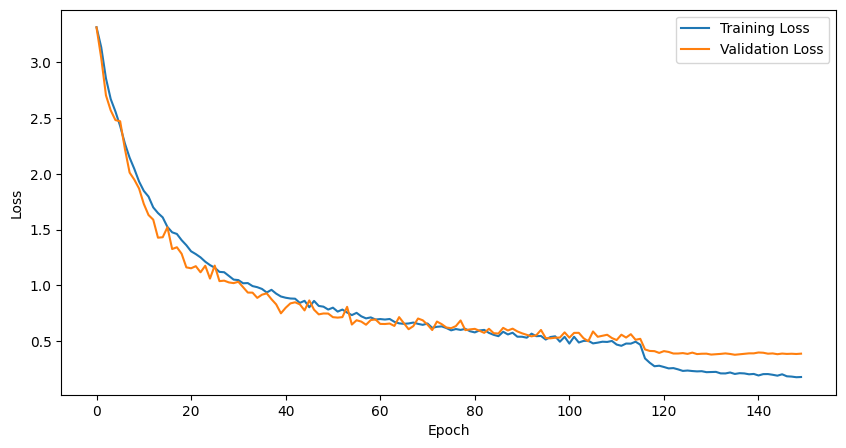

In [ ]:
print("CONFIGS", end=" || ")
for k, v in CONFIGS.items():
  print(k, v, end=' | ')
print()
print("OPTIM ||", optimizer)
print("LR SCHD ||", lr_scheduler)
print("MODEL ||", model.__class__.__name__)
print("-" * 50)

if end_epoch == 0:
    print(f"Start training... [EXP_NAME] : {EXP_NAME}")
else:
    print(f"Resume training from epoch = {start_epoch}... [EXP_NAME] : {EXP_NAME}")

end_epoch = end_epoch if end_epoch else CONFIGS["num_epochs"]

# Training loop
for i, epoch in enumerate(range(start_epoch, end_epoch)):
    # Training
    model.train()
    train_loss = 0.0
    start_time = time.time()

    if CONFIGS["warmup_lr"]:
        warmup_lr_scheduler(epoch, lr_max=CONFIGS["initial_learning_rate"])

    for images, labels in tqdm(train_data_loader):

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        # outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)


    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_data_loader):
            images = images.to(device)
            labels = labels.to(device)

            # outputs, _ = model(images)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    lr_scheduler.step(metrics=val_loss)

    print(f"Epoch [{epoch+1}/{end_epoch}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.5f} ({(time.time() - start_time):.1f} secs/epoch)")

    if (epoch + 1) % 30 == 0:
      if not os.path.exists(f'exp/{EXP_NAME}'):
        os.makedirs(f'exp/{EXP_NAME}')
      torch.save({
          'epoch': epoch + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
      },  f'exp/{EXP_NAME}/mobilevit_{epoch+1}.pt')
      print(f"Saved model @ epoch = {str(epoch+1)}")

print("Training completed.")

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6. Evaluation on TEST SET

In [ ]:
import torch
from sklearn.metrics import accuracy_score

EXP_NAME_1 = "DA_LRS_MobileViT_IR_seed"
EXP_NAME_2 = "LRS_MobileViT_IR_seed"
LOADING_EPOCH = 150

# model = mobilevit_xs()
model = mobilevitIR_xs()

PATH_1 = f"exp/{EXP_NAME_1}/mobilevit_{LOADING_EPOCH}.pt"
train_loss_1 = torch.load(PATH_1, weights_only=True)["train_losses"]
val_loss_1 = torch.load(PATH_1, weights_only=True)["val_losses"]
print(len(train_loss_1), len(val_loss_1))
print(f"Loaded ckpt from '{PATH_1}'")

PATH_2 = f"exp/{EXP_NAME_2}/mobilevit_{LOADING_EPOCH}.pt"
train_loss_2 = torch.load(PATH_2, weights_only=True)["train_losses"]
val_loss_2 = torch.load(PATH_2, weights_only=True)["val_losses"]
print(len(train_loss_2), len(val_loss_2))
print(f"Loaded ckpt from '{PATH_2}'")

150 150
Loaded ckpt from 'exp/DA_LRS_MobileViT_IR_seed/mobilevit_150.pt'
150 150
Loaded ckpt from 'exp/LRS_MobileViT_IR_seed/mobilevit_150.pt'


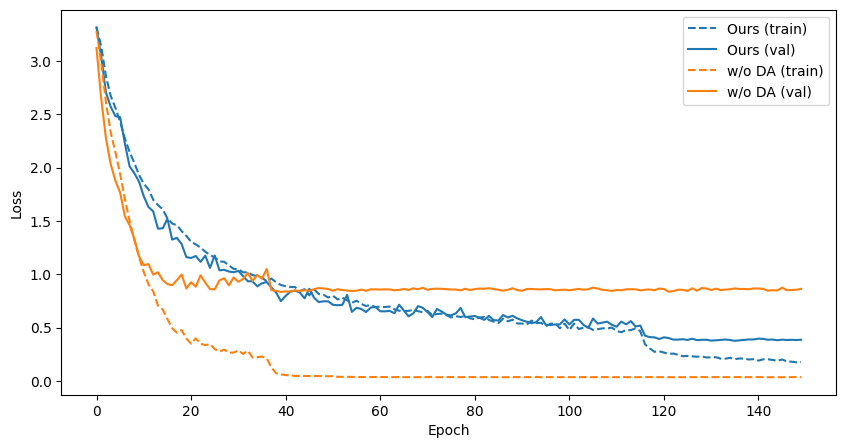

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss_1, color='tab:blue', label='Ours (train)', linestyle='dashed')
plt.plot(val_loss_1, color='tab:blue', label='Ours (val)', linestyle='-')
plt.plot(train_loss_2, color='tab:orange', label='w/o DA (train)', linestyle='dashed')
plt.plot(val_loss_2, color='tab:orange', label='w/o DA (val)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

EXP_NAME = "DA_LRS_MobileViT_seed"
LOADING_EPOCH = 150

# model = mobilevit_xs()
model = mobilevitIR_xs()
# model = mobilevitIRv2_xs()

PATH = f"exp/{EXP_NAME}/mobilevit_{LOADING_EPOCH}.pt"
ckpt = torch.load(PATH, weights_only=True)["model_state_dict"]
model.load_state_dict(ckpt, map_location="cpu")
print(f"Loaded ckpt from '{PATH}'")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"\nTest Accuracy: {accuracy:.2f}%")

<ipython-input-17-a152f0bb1226>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(PATH)["model_state_dict"]


Loaded ckpt from 'exp/DA_LRS_MobileViT_IR_seed/mobilevit_150.pt'


100%|██████████| 94/94 [08:34<00:00,  5.48s/it]


Test Accuracy: 90.20%


#### 6-1. Visualization of model prediction

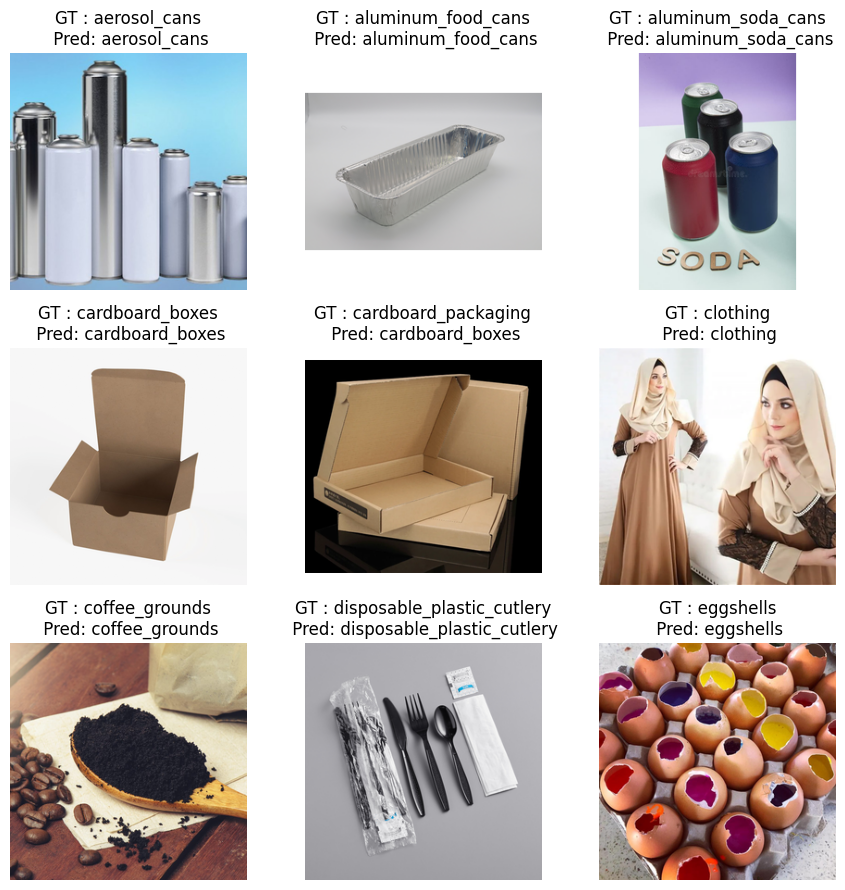

In [ ]:
import numpy as np

# Perform sample inferences on test images with different labels
model.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    # random.shuffle(indices)

    selected_images = []
    selected_labels = []
    selected_predicted = []

    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to(device)

        output = model(image)
        _, predicted = torch.max(output, 1)

        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())

        if len(selected_labels) == 9:
            break

    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    axes = axes.flatten()

    std = torch.tensor(IMAGENET_DEFAULT_STD)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN)

    for i in range(9):
        visual_image = selected_images[i].squeeze().cpu()
        visual_image = visual_image * std[:, None, None] + mean[:, None, None]
        visual_image = torch.clamp(visual_image, 0, 1).permute(1, 2, 0)
        axes[i].imshow(visual_image)
        axes[i].set_title(f"GT : {train_dataset.classes[selected_labels[i]]}\n Pred: {train_dataset.classes[selected_predicted[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()